## Orientation detection using color markers
This concerns the original Bioniko eye model with added color markers.

### 1. Imports

In [113]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [114]:
from helpers.limbus_detection import detect_circle

### 2. Constants and helper functions

In [115]:
SCLERA_TO_LIMBUS_RATIO = 1.7
PLANAR_SCLERA_TO_LIMBUS_RATIO = 1.25

In [116]:
def linear_polar_warp(img: np.array, center: tuple, max_radius: int, min_radius: int = -1,
                      flags=cv2.INTER_LINEAR) -> np.array:
    linear_polar = cv2.warpPolar(img, (0, 0), tuple(
        center), max_radius, cv2.WARP_POLAR_LINEAR+cv2.WARP_FILL_OUTLIERS)
    linear_polar = cv2.rotate(linear_polar, cv2.ROTATE_90_CLOCKWISE)
    linear_polar = cv2.resize(linear_polar, (0, 0), fx=2.0, fy=1.0)

    if min_radius > 0:
        linear_polar = linear_polar[round(min_radius):, :]

    return linear_polar

### 3. Basic visualizations

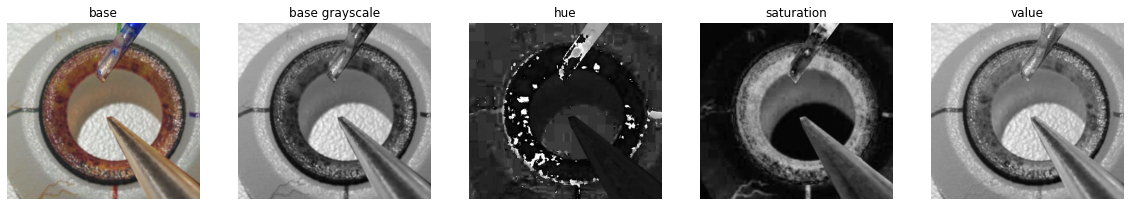

In [117]:
base = cv2.imread('data/artificial/with_markers5.jpeg', cv2.IMREAD_COLOR)
base_rgb = cv2.cvtColor(base, cv2.COLOR_BGR2RGB)
base_gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)

base_hue = base_hsv[:, :, 0]
base_saturation = base_hsv[:, :, 1]
base_value = base_hsv[:, :, 2]

fig, (plot1, plot2, plot3, plot4, plot5) = plt.subplots(1, 5, figsize=(20, 10))
plot1.set_title('base')
plot1.imshow(base_rgb)
plot1.axis('off')

plot2.set_title('base grayscale')
plot2.imshow(base_gray, cmap=plt.cm.gray)
plot2.axis('off')

plot3.set_title('hue')
plot3.imshow(base_hue, cmap=plt.cm.gray)
plot3.axis('off')

plot4.set_title('saturation')
plot4.imshow(base_saturation, cmap=plt.cm.gray)
plot4.axis('off')

plot5.set_title('value')
plot5.imshow(base_value, cmap=plt.cm.gray)
plot5.axis('off')

plt.show()

In [118]:
scale = 0.4
base_gray_small = cv2.resize(base_gray, (0, 0), fx=scale, fy=scale)
base_gray_small.shape

(158, 173)

### 4. Limbus detection

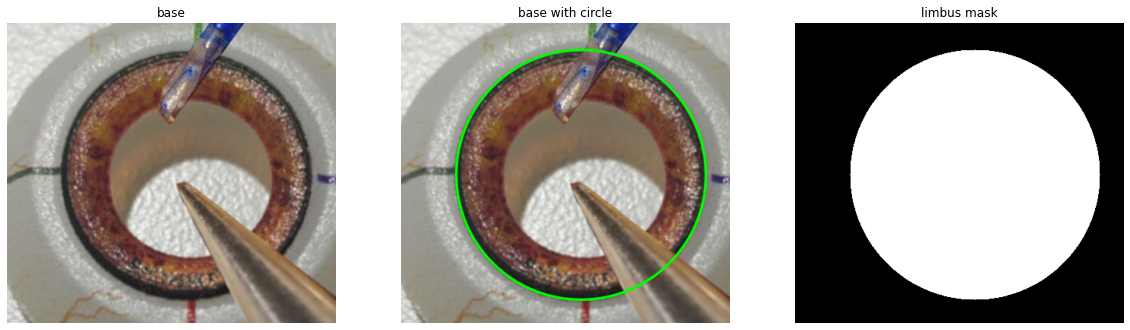

In [119]:
best_circle = detect_circle(base_value, validation='inout', validation_mode='max',
                            considered_ratio_s=1.0, circle_width_to_radius_ratio=0.04)
center, radius = best_circle[:2], best_circle[2]

limbus_mask = np.zeros(base_value.shape)
cv2.circle(limbus_mask, (round(center[0]), round(center[1])),
           round(radius), 255, cv2.FILLED)

base_vis = base_rgb.copy()
cv2.circle(base_vis, (round(center[0]), round(center[1])),
           round(radius), (0, 255, 0), 2, cv2.LINE_AA)

fig, (plot1, plot2, plot3) = plt.subplots(1, 3, figsize=(20, 10))
plot1.set_title('base')
plot1.imshow(base_rgb)
plot1.axis('off')

plot2.set_title('base with circle')
plot2.imshow(base_vis)
plot2.axis('off')

plot3.set_title('limbus mask')
plot3.imshow(limbus_mask, cmap=plt.cm.gray)
plot3.axis('off')

plt.show()

### 5. Color segmentation
HSV color space thresholds for each of the color strips. See [wiki](https://en.wikipedia.org/wiki/HSL_and_HSV) and OpenCV [docs](https://docs.opencv.org/4.x/df/d9d/tutorial_py_colorspaces.html) for more info on the ins and outs of this kind of color processing.

In [120]:
red_llth = np.array([165, 100, 50])
red_luth = np.array([179, 255, 255])
red_ulth = np.array([0, 100, 50])
red_uuth = np.array([15, 255, 255])

green_lth = np.array([35, 50, 50])
green_uth = np.array([70, 255, 255])

blue_lth = np.array([100, 75, 50])
blue_uth = np.array([150, 255, 255])

black_lth = np.array([0, 0, 0])
black_uth = np.array([179, 40, 170])


def segment_color(hsv: np.array, color: str) -> np.array:
    if color == 'red':
        red_l = cv2.inRange(hsv, red_llth, red_luth)
        red_u = cv2.inRange(hsv, red_ulth, red_uuth)
        result = cv2.bitwise_or(red_l, red_u)
    elif color == 'green':
        result = cv2.inRange(hsv, green_lth, green_uth)
    elif color == 'blue':
        result = cv2.inRange(hsv, blue_lth, blue_uth)
    elif color == 'black':
        result = cv2.inRange(hsv, black_lth, black_uth)
    else:
        raise ValueError('unknown color: %s' % color)

    return result

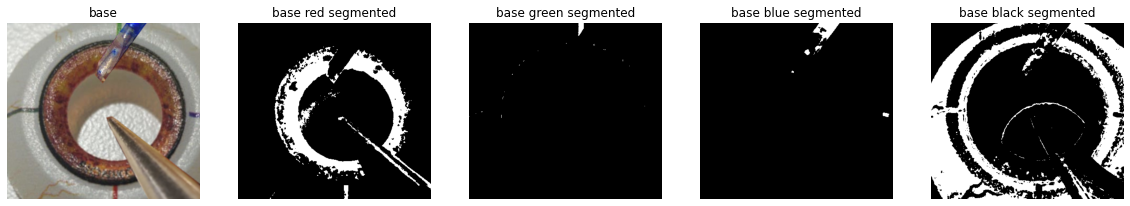

In [121]:
fig, (plot1, plot2, plot3, plot4, plot5) = plt.subplots(1, 5, figsize=(20, 10))
plot1.set_title('base')
plot1.imshow(base_rgb)
plot1.axis('off')

plot2.set_title('base red segmented')
plot2.imshow(segment_color(base_hsv, 'red'), cmap=plt.cm.gray)
plot2.axis('off')

plot3.set_title('base green segmented')
plot3.imshow(segment_color(base_hsv, 'green'), cmap=plt.cm.gray)
plot3.axis('off')

plot4.set_title('base blue segmented')
plot4.imshow(segment_color(base_hsv, 'blue'), cmap=plt.cm.gray)
plot4.axis('off')

plot5.set_title('base black segmented')
plot5.imshow(segment_color(base_hsv, 'black'), cmap=plt.cm.gray)
plot5.axis('off')

plt.show()

### 6. Hough line transform
Let's try to detect the line green line strip and determine the eye orientation this way.

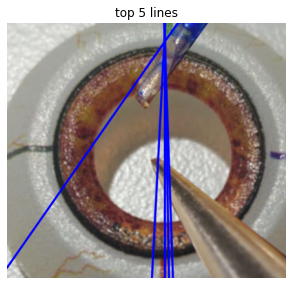

In [122]:
base_green = segment_color(base_hsv, 'green')
lines = cv2.HoughLines(cv2.Canny(base_green, 0, 255), 1, np.pi / 180, 1)

base_test = base_rgb.copy()
for line in lines[:5]:
    line = line[0]
    rho = line[0]
    theta = line[1]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 2000*(-b)), int(y0 + 2000*(a)))
    pt2 = (int(x0 - 2000*(-b)), int(y0 - 2000*(a)))
    cv2.line(base_test, pt1, pt2, (0, 0, 255), 2, cv2.LINE_AA)

fig, plot = plt.subplots(1, 1, figsize=(5, 5))
plot.set_title('top 5 lines')
plot.imshow(base_test)
plot.axis('off')

plt.show()

This approach is not really feasible because of the amount of false positive pixels introduced during the color segmentation. We need focus closely on just the narrow ring around the limbus.

### 7. Polar warp
The idea here is to exploit the fact we already have the limbus detection. Because of this we can polar warp the image using the detected center and scale. This has the somewhat unfortunate effect that we are introducing dependence on this detection's accuracy.

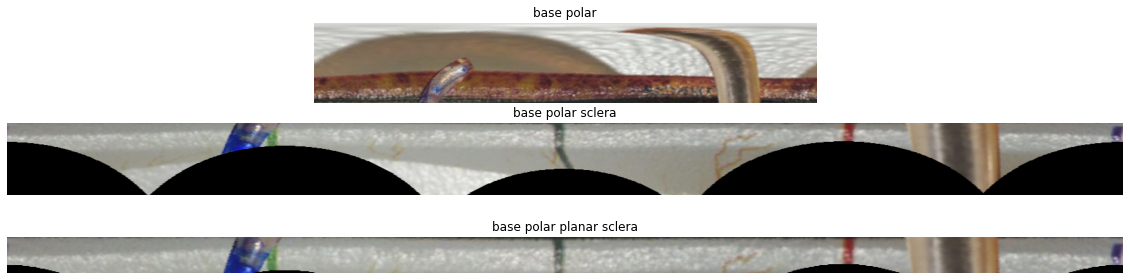

In [123]:
fig, (plot1, plot2, plot3) = plt.subplots(3, 1, figsize=(20, 5))
plot1.set_title('base polar')
plot1.imshow(linear_polar_warp(base_rgb, center, radius))
plot1.axis('off')

plot2.set_title('base polar sclera')
plot2.imshow(linear_polar_warp(base_rgb, center,
             radius*SCLERA_TO_LIMBUS_RATIO, radius))
plot2.axis('off')

plot3.set_title('base polar planar sclera')
plot3.imshow(linear_polar_warp(base_rgb, center, radius *
             PLANAR_SCLERA_TO_LIMBUS_RATIO, radius))
plot3.axis('off')

plt.show()

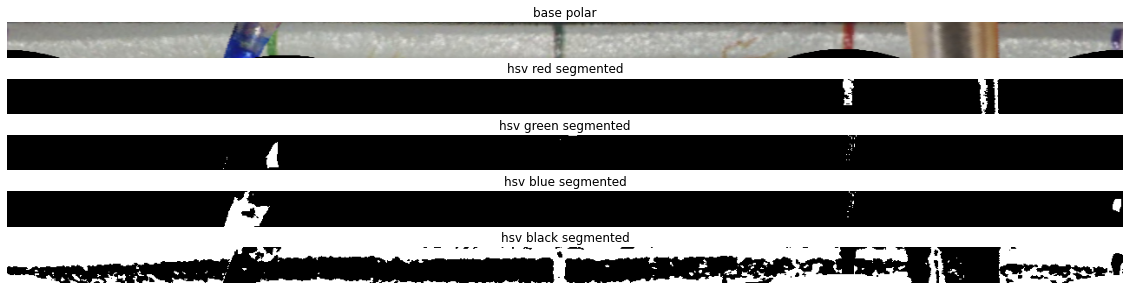

In [124]:
base_hsv_polar = linear_polar_warp(
    base_hsv, center, radius*PLANAR_SCLERA_TO_LIMBUS_RATIO, radius)
red_polar = segment_color(base_hsv_polar, 'red')
green_polar = segment_color(base_hsv_polar, 'green')
blue_polar = segment_color(base_hsv_polar, 'blue')
black_polar = segment_color(base_hsv_polar, 'black')

fig, (plot1, plot2, plot3, plot4, plot5) = plt.subplots(5, 1, figsize=(20, 5))
plot1.set_title('base polar')
plot1.imshow(linear_polar_warp(base_rgb, center, radius *
             PLANAR_SCLERA_TO_LIMBUS_RATIO, radius))
plot1.axis('off')

plot2.set_title('hsv red segmented')
plot2.imshow(red_polar, cmap=plt.cm.gray)
plot2.axis('off')

plot3.set_title('hsv green segmented')
plot3.imshow(green_polar, cmap=plt.cm.gray)
plot3.axis('off')

plot4.set_title('hsv blue segmented')
plot4.imshow(blue_polar, cmap=plt.cm.gray)
plot4.axis('off')

plot5.set_title('hsv black segmented')
plot5.imshow(black_polar, cmap=plt.cm.gray)
plot5.axis('off')

plt.show()

As the individual color strip segmentations are not perfect (due to reflections, oclussions, etc.) we should based the orientation on all of them at once for higher robustness. From now on we ditch the black strip as it appears to be the most unreliable one.

### 8. Stacking color strips
When the camera view is parallel to the eye model we can consider the color strips to be 90 degrees apart along the limbus. Using this knowledge, we can align them in the polar space vertically.

In [125]:
def stack_vertical(strips, split=0.24):
    width = strips[0].shape[1]
    height = strips[0].shape[0]
    result = np.zeros((height*len(strips), width))
    for i, strip in enumerate(strips):
        split_th = round((i*split % 1.0) * width)
        result[i*height:(i+1)*height, width-split_th:] = strip[:, 0:split_th]
        result[i*height:(i+1)*height, :width-split_th] = strip[:, split_th:]

    return result

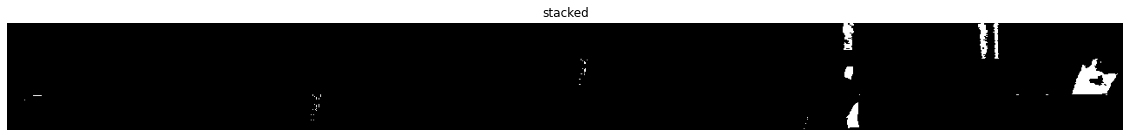

In [126]:
stacked = stack_vertical((red_polar, blue_polar, green_polar))

fig, plot1 = plt.subplots(1, 1, figsize=(20, 5))
plot1.set_title('stacked')
plot1.imshow(stacked, cmap='gray')
plot1.axis('off')

plt.show()

### 9. Determining the orientation from the stacked strips

#### 9.1 Vertical sum
Can fail when instruments involved (and similar occlusions).

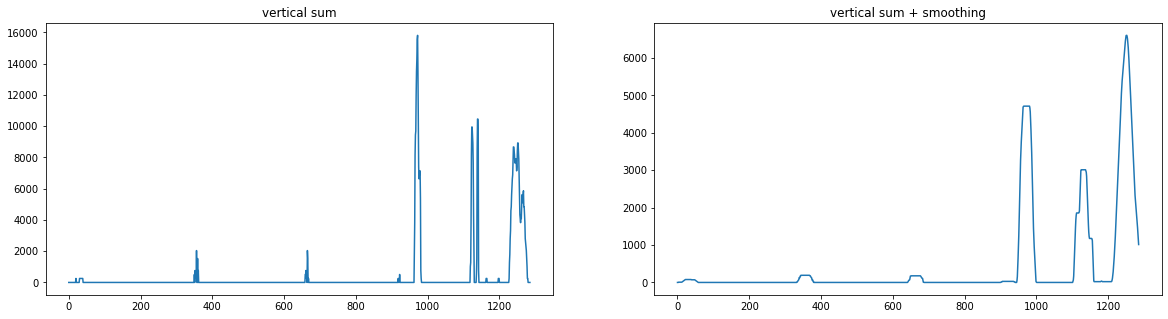

max: 6601.666666666666, argmax: 1251


In [127]:
vertical_sum = np.sum(stacked, axis=0)
box_kernel_width = round(vertical_sum.size/36)
box_kernel = np.ones(box_kernel_width)/box_kernel_width
vertical_sum_smooth = np.convolve(vertical_sum, box_kernel, mode='same')

fig, (plot1, plot2) = plt.subplots(1, 2, figsize=(20, 5))
plot1.set_title('vertical sum')
plot1.plot(vertical_sum)

plot2.set_title('vertical sum + smoothing')
plot2.plot(vertical_sum_smooth)

plt.show()

print('max: %s, argmax: %s' % (
    np.max(vertical_sum_smooth),
    np.argmax(vertical_sum_smooth)
))

#### 9.2 Hu moments for calculating vertical variance
This is a more promising measure. It is not invariant to the order of color strips as demonstrated below.

In [128]:
def get_moments_mu02(img: np.array) -> np.array:
    window_width = 16
    moments = []
    for i in range(360):
        window_center = round(i*img.shape[1]/360)
        window = img[
            :,
            max(0, window_center-window_width//2):min(img.shape[1], window_center+window_width//2)
        ]
        moments.append(cv2.moments(window, binaryImage=True)['mu02'])

    return moments

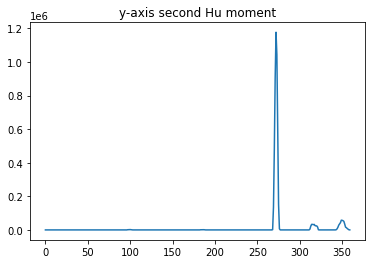

In [129]:
plt.title('y-axis second Hu moment')
plt.plot(get_moments_mu02(stacked))
plt.show()

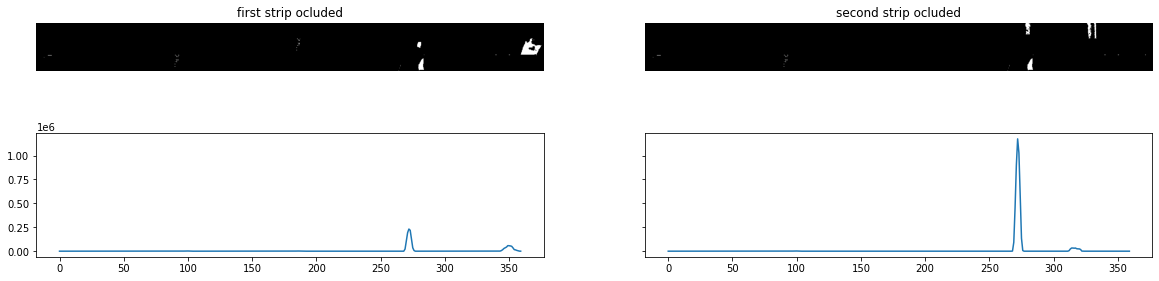

In [130]:
stacked_first_ocluded = stacked.copy()
stacked_first_ocluded[:stacked_first_ocluded.shape[0]//3, :] = 0

stacked_second_ocluded = stacked.copy()
stacked_second_ocluded[stacked_second_ocluded.shape[0] //
                       3:2*stacked_second_ocluded.shape[0]//3, :] = 0

fig, plots = plt.subplots(2, 2, figsize=(20, 5), sharey='row')
plots[0, 0].set_title('first strip ocluded')
plots[0, 0].imshow(stacked_first_ocluded, cmap='gray')
plots[0, 0].axis('off')

plots[0, 1].set_title('second strip ocluded')
plots[0, 1].imshow(stacked_second_ocluded, cmap='gray')
plots[0, 1].axis('off')

plots[1, 0].plot(get_moments_mu02(stacked_first_ocluded))

plots[1, 1].plot(get_moments_mu02(stacked_second_ocluded))

plt.show()

#### 9.3 Custom measure
1. We slide a vertical window along the stacked strips
2. For each location we sum horizontally
3. Normalize the vertical vector to probability distribution
4. Compute the entropy of this distribution
5. Find location of maximum entropy

This measure does not give so clear optima as the previous ones. However, it is much more stable.

In [131]:
window_width = round(20*stacked.shape[1]/360)
measure = []
for i in range(360):
    window_center = round(i*stacked.shape[1]/360)
    window = stacked[
        :,
        max(0, window_center-window_width//2):min(stacked.shape[1], window_center+window_width//2)
    ]

    measure.append(np.sum(window, axis=1))

measure = np.array(measure)

In [132]:
entropy = []
for i in range(measure.shape[0]):
    values = measure[i, :]
    values = values[values != 0]
    if values.shape[0] == 0:
        entropy.append(0)
        continue

    values = values / np.sum(values)
    entropy.append(np.sum(np.multiply(-values, np.log(values))))

entropy = np.array(entropy)

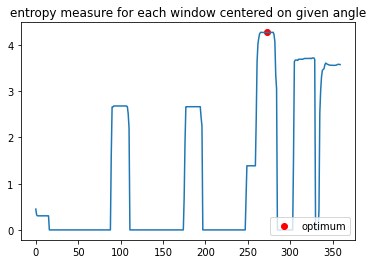

In [133]:
entropy_eps = np.log(0.8)

max_entropy = np.max(entropy)
optimal_degs = np.where(entropy > (max_entropy + entropy_eps))
optimum = np.median(optimal_degs)

plt.title('entropy measure for each window centered on given angle')
plt.plot(entropy)
plt.scatter(optimum, max_entropy, color='red', label='optimum')
plt.legend(loc='lower right')
plt.show()

### 10. Additional tests (unstructured)

In [134]:
polar_value = linear_polar_warp(
    base_hsv[:, :, 2], center, radius*PLANAR_SCLERA_TO_LIMBUS_RATIO, radius)

plt.imshow(polar_value, cmap='gray')
plt.axis('off')
plt.show()

In [135]:
_, th = cv2.threshold(polar_value, 0, 255,
                      cv2.THRESH_OTSU+cv2.THRESH_BINARY_INV)
th[polar_value == 0] = 0

plt.imshow(th, cmap='gray')
plt.axis('off')
plt.show()

This is promising, as it skips the unstable color segmentation.

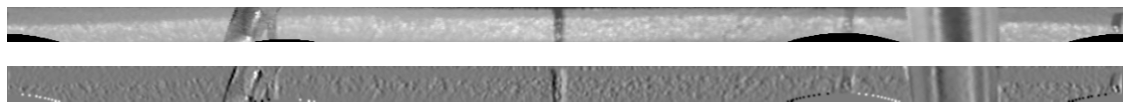

In [136]:
test = linear_polar_warp(
    base_hsv[:, :, 2], center, radius*PLANAR_SCLERA_TO_LIMBUS_RATIO, radius)
sobelx = cv2.Sobel(test, cv2.CV_64F, 1, 0, ksize=5)

fig, (plot1, plot2) = plt.subplots(2, 1, figsize=(20, 2))
plot1.imshow(test, cmap='gray')
plot1.axis('off')
plot2.imshow(sobelx, cmap='gray')
plot2.axis('off')

plt.show()

In [137]:
v = np.sort(np.abs(sobelx.ravel()))
th = v[round(v.size * 0.95)]

mask = np.zeros(test.shape)
mask[sobelx > th] = 255

plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()